# Two chargers stochastic simulation

* Vehicles arrive at rate $\lambda$ uniformly distributed in [0,1].
* There are two chargers C1 and C2 with infinite capacity.
* Vehicles require a charging time $\exp(\mu)$ after which they depart.
* Initially, they choose the nearest charger.

In [199]:
using Distributions, Plots

#Objeto que representa al cargador.
mutable struct Charger
    position::Float64
    currentOccupation::Integer
    currentPrice::Float64
    totalPower::Float64
    mu::Float64
    Charger(position::Float64) = new(position,0,0.0,5.0, 0.0)
end

#Objeto que representa al EV
mutable struct EV
    arrivalTime::Float64
    arrivalPosition::Float64
    requiredEnergy::Float64
    assignedCharger::Union{Charger,Nothing}
    departureTime::Float64
    EV(arrivalTime::Float64,arrivalPosition::Float64,requiredEnergy::Float64) = new(arrivalTime,arrivalPosition,requiredEnergy,nothing,NaN)
end

#auxiliar
function compute_distance(ev::EV,c::Charger)
    return abs(ev.arrivalPosition - c.position)
end

function update_energy!(ev::EV,dt::Float64)
    ev.requiredEnergy = ev.requiredEnergy-dt
    # min {ev.assignegCharger.totalPower / ev.assignegCharger.currentoccupation, 1};
end


update_energy! (generic function with 1 method)

In [200]:
function TimeForNextEvent()
    
    dt,event = findmin([timeForNextArrival, timeForNextDeparture]);
        
    return dt, event;
end

TimeForNextEvent (generic function with 1 method)

In [201]:
function UpdateEnergyForAllCars()
     map(ev->update_energy!(ev,timeForEvent), chargingEVs)
end

UpdateEnergyForAllCars (generic function with 1 method)

In [202]:
function CreateEV()
    return EV(currentTime,rand(dist_position), rand(dist_energy))
end

CreateEV (generic function with 1 method)

In [203]:
function AddEVToChargingEVList(ev::EV)
     push!(chargingEVs,ev)
end

AddEVToChargingEVList (generic function with 1 method)

In [222]:
function GetIndexToNearestChargerToCar(ev::EV)
    
     distances = compute_distance.(Ref(ev), chargers)  #el Ref es para que el . opere solo sobre los chargers
     distance,idx = findmin(distances)
    
    return distance, idx;
    
end

GetIndexToNearestChargerToCar (generic function with 1 method)

In [231]:
function GetOptimalChargerToCar(ev::EV)
    
    min_price = Inf;
    optimal_charger = nothing;
    
    for charger in chargers
        
        distance = compute_distance(ev, charger);
        mu = charger.mu;
        
        price = distance + mu;
        
        if price < min_price
            min_price = price;
            optimal_charger = charger;
        end
        
    end
    
end

GetOptimalChargerToCar (generic function with 1 method)

In [205]:
function IncreaseNearestChargerOcupation(index)
    chargers[index].currentOccupation = chargers[index].currentOccupation + 1
end

IncreaseNearestChargerOcupation (generic function with 1 method)

In [223]:
function AssignOptimalChargerToCar(ev::EV)
    
    distance, idx = GetIndexToNearestChargerToCar(ev);
       
    ev.assignedCharger = chargers[idx];
    
    #TODO
    #Cada auto debe elegir el mas "barato" : min precio + distancia
    
    IncreaseNearestChargerOcupation(idx);
    
end

AssignNearestChargerToCar (generic function with 1 method)

In [207]:
function IsACarCharging()
    return c1.currentOccupation + c2.currentOccupation > 0;
end

IsACarCharging (generic function with 1 method)

In [208]:
function GetCarAndTimeRemainingForClosestDeparture()
    
    global timeForNextDeparture, nextCarToFinish;
    
    timeForNextDeparture,nextCarToFinish = findmin([ev.requiredEnergy for ev in chargingEVs])
    
    return timeForNextDeparture, nextCarToFinish;
    
end

GetCarAndTimeRemainingForClosestDeparture (generic function with 1 method)

In [209]:
function SetDepartureTimeOfEV(ev_index)
    chargingEVs[ev_index].departureTime = currentTime;
end

SetDepartureTimeOfEV (generic function with 1 method)

In [210]:
function AddEVToFinishedEVsList(ev_index)
     push!(finishedEVs, chargingEVs[ev_index])
end

AddEVToFinishedEVsList (generic function with 1 method)

In [211]:
function DecreaseChargerOccupationOfEV(ev_index)
    chargingEVs[ev_index].assignedCharger.currentOccupation = chargingEVs[ev_index].assignedCharger.currentOccupation - 1;
end

DecreaseChargerOccupationOfEV (generic function with 1 method)

In [212]:
function RemoveEVFromChargingEVList(ev_index)
    deleteat!(chargingEVs,ev_index);
end

RemoveEVFromChargingEVList (generic function with 1 method)

In [213]:
function UpdateGraphsData()
     
    push!(T,currentTime) 
    
    for i = 1:amountOfChargers
        push!(Occupations[i], chargers[i].currentOccupation);
    end

end

UpdateGraphsData (generic function with 1 method)

In [214]:
function ProcessArrival()
    
   global timeForNextArrival;
    
   new_ev = CreateEV();
        
   AddEVToChargingEVList(new_ev);

   AssignNearestChargerToCar(new_ev);

   timeForNextArrival = rand(dist_arrivals);
    
end

ProcessArrival (generic function with 1 method)

In [215]:
function ProcessDeparture()
    
    SetDepartureTimeOfEV(nextCarToFinish);
        
    AddEVToFinishedEVsList(nextCarToFinish);
        
    DecreaseChargerOccupationOfEV(nextCarToFinish);
        
    RemoveEVFromChargingEVList(nextCarToFinish);
    
end

ProcessDeparture (generic function with 1 method)

In [216]:
function AssignCarAndTimeRemainingForClosestDepartureIfExists()

    global timeForNextDeparture, nextCarToFinish;
    
    if IsACarCharging()
        timeForNextDeparture, nextCarToFinish = GetCarAndTimeRemainingForClosestDeparture();
    else
        timeForNextDeparture = Inf
        nextCarToFinish = nothing
    end
    
end

AssignCarAndTimeRemainingForClosestDepartureIfExists (generic function with 1 method)

In [232]:
function Simulate()
    
    global currentTime;
    global timeForEvent;
    global timeForNextArrival;
    global timeForNextDeparture;
    global nextEvent;
        
    while currentTime < finalTime
    
        currentTime = currentTime + timeForEvent
        
        #Restar tiempo de departure
        timeForNextArrival = timeForNextArrival - timeForEvent #DUDA

        UpdateEnergyForAllCars();
        
        #UpdatePricesAndPower()
        
            # Guardo mu anterior para calcular nuevo s
        
            # Nuevo mu es mu anterior + timeForEvent * (occupation_c - s_c) | por cada cargador
        
            # Nuevo s es s anterior + timeForEvent * (mu anterior - s_anterior) | por cada cargador

        if nextEvent == Arrival

           new_ev = CreateEV();
        
           AddEVToChargingEVList(new_ev);

           AssignNearestChargerToCar(new_ev);

           timeForNextArrival = rand(dist_arrivals);

        elseif nextEvent == Departure 
            
            SetDepartureTimeOfEV(nextCarToFinish);
        
            AddEVToFinishedEVsList(nextCarToFinish);
        
            DecreaseChargerOccupationOfEV(nextCarToFinish);
        
            RemoveEVFromChargingEVList(nextCarToFinish);

        end

        UpdateGraphsData();

        AssignCarAndTimeRemainingForClosestDepartureIfExists();

        timeForEvent, nextEvent = TimeForNextEvent();


     end
    
end

Simulate (generic function with 1 method)

In [218]:
#using Printf
lambda = 100.0 #autos por hora
mu= 0.5   #2 horas de carga

finalTime = 100

c1 = Charger(0.5)
c2 = Charger(1.0)

chargers = [c1;c2]

amountOfChargers = size(chargers)[1];

chargingEVs = EV[]   #lista de vehiculos en el sistema

finishedEVs = EV[] #lista de vehiculos que terminaron (para estadistica)

dist_arrivals = Exponential(1/lambda)   #hay que pasarle la media no el parámetro
dist_energy = Exponential(1/mu)   #hay que pasarle la media no el parámetro
dist_position = Uniform(0,1)

currentTime = 0.0
T=[currentTime]

#Ocupacion por cargador
C1=[c1.currentOccupation]
C2=[c2.currentOccupation]

Occupations = [C1, C2];

timeForNextArrival = rand(dist_arrivals)
timeForNextDeparture = Inf

Arrival = 1;
Departure = 2;

nextCarToFinish = nothing  #Esto apunta a un vehiculo del array EVs que es el de menor remanente

timeForEvent, nextEvent = TimeForNextEvent();

Simulate();

In [233]:
mean(Occupations[1])

146.04527787592752

In [234]:
mean(Occupations[2])

50.941699056079955

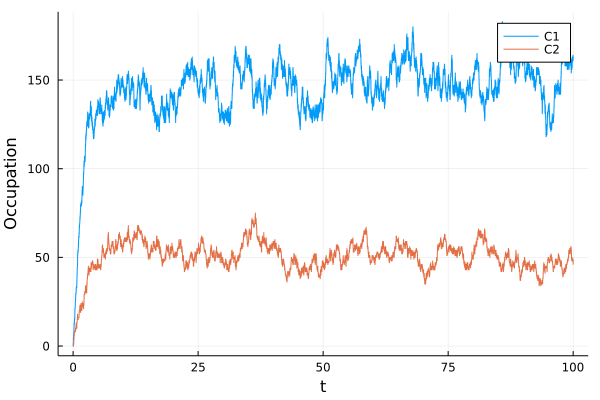

In [235]:
plot(T, Occupations[1], lt=:steppost, label = "C1")
plot!(T, Occupations[2], lt=:steppost, label = "C2")
xlabel!("t")
ylabel!("Occupation")

0.827553727063536
0.0037553880378977667
0.013482975479335746
0.84765625940243
0.6229087982055421
0.7581674284280491
0.44725019499680196
0.43669315568688694
0.6285401278395548
0.9381176676495131
0.0006818031303195138
0.8072067249272201
0.305130809315862
0.4083565343961917
0.25328816982568836
0.553836861498201
0.06709087516425649
0.6967760996024484
0.40611377551947125
0.7741455765661254
0.11973785405023518
0.6808173534915214
0.44442704203177597
0.43515969263150556
0.16878038274732665
0.16870371773729942
0.5643681906410949
0.2028354860606938
0.25808337765658584
0.2357929248175672
0.44962194996368043
0.417358196553244
0.11233850605617413
0.11019053862108441
0.5529462674390517
0.03578788710964753
0.916872352040454
0.3359069813558182
0.20888256395245675
0.710205560141393
0.8439539120956507
0.5431807919221945
0.7578501119738079
0.3401718528039548
0.48008540411961276
0.9026096695476584
0.1938524728753077
0.526860560086734
0.3606396301253991
0.8904178149335327
0.7345859258071359
0.8804439495967